# Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [20]:
from IPython.core.display import HTML, Markdown, display
import pandas as pd
CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [21]:
import csv
# import os
from matplotlib.pylab import *
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [47]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)
import copy
data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data
copy_data_train=copy.deepcopy(data_train)
Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data
print("Data retrieval done")

Data retrieval done


**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [23]:
M_train = data_train

M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k])
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set
print('Data normalization with a for loop is done')

Data normalization with a for loop is done


In [24]:
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ]).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ])
sigma = np.array( [ np.std(vec) for vec in data_train[:,0:8].T ])

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T
print('Data normalization with a lambda function is done')

Data normalization with a lambda function is done


# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

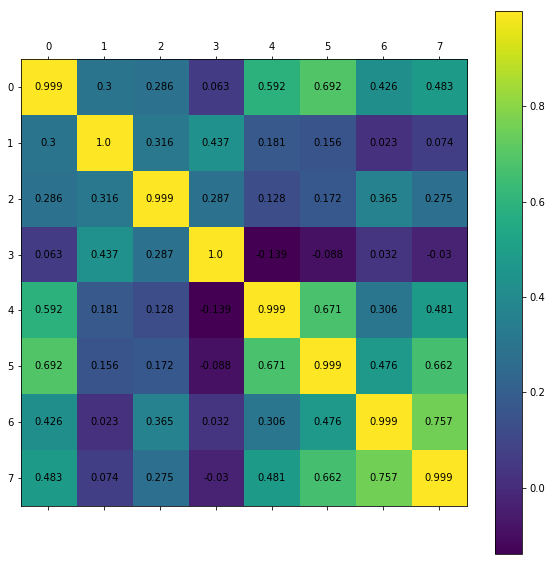

In [25]:
# Preliminary questions
import numpy as np
import matplotlib.pyplot as plt

cov_matrix=np.corrcoef(M_train, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
# f = plt.figure(figsize=(5,5))
min_val, max_val = 0, 8
for i in range(8):
    for j in range(8):
        c = int(cov_matrix[j][i]*1000)/1000
        ax.text(i, j, str(c), va='center', ha='center')

Im=ax.matshow(cov_matrix)
plt.colorbar(Im, ax=ax) 


# Comments on covariance results : 
### According to the correlation table, we can see that the correlation between some features is high :
- Between the feature indexed by 0 and the one index by 5.
- Between the feature indexed by 4 and the one index by 5.
- Between the feature indexed by 5 and the one index by 7.
- Between the feature indexed by 6 and the one index by 7.

### From this first statistical description of the problem, we can already say that we can reduce the dimensionality of the problem and so the number of features. And in this case, we can speculate and say that the features indexed 5, 6 and 7 may already be omitted beacause of being highly correlated with the feature indexed by 4, but we still have to make a more elaborated statistical test to select  the main fatures of the problem, which is the objectif of the Z-scores method in the exercice number 1.

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [26]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

In [27]:
# Exercise 1

# Build the matrix of features X_train for the training set
t_train = copy_data_train[:,8]
N_train = copy_data_train.shape[0]
X_train = np.concatenate((np.ones((N_train,1)), M_train[:,0:8]), axis=1) 
# Estimate the regression vector beta_hat
Moore_Inverse=dot(la.inv(dot(X_train.T,X_train)),X_train.T)
beta_hat=dot(Moore_Inverse, t_train)
df=pd.DataFrame(beta_hat,columns=["Beta_hat Coefficients"])
display(df)

# The meaning behind beta_hat[0], the first coefficient of the regression estimated vector
display(Markdown('### -The value of the first coefficient is <font color=\'red\'>\"{intercept}\"</font> and it is called the intercept or the bias (not the statistical bias) and insures that the mean of our residuals is null'.format(intercept=beta_hat[0])))

# Estimate the prediction error (quadratic error) from the test set.
error=la.norm([dot(X_test,beta_hat)[i]-t_test[i]  for i in range(len(t_test))],2)
display(Markdown('## $$E_ls =\\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = '+str((1/len(t_test))*error)+'$$'))


,Beta_hat Coefficients
0,2.452345
1,0.711041
2,0.290450
3,-0.141482
4,0.210420
5,0.307300
6,-0.286841
7,-0.020757
8,0.275268


### -The value of the first coefficient is <font color='red'>"2.4523450850746267"</font> and it is called the intercept or the bias (not the statistical bias) and insures that the mean of our residuals is null

## $$E_ls =\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = 0.13181729849904644$$

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [28]:
# Exercise 2

display(Markdown('# <font color=\'red\'>Question 1</font>'))
# Compute the Z-scores
p=8
N=len(t_train)
beta=beta_hat
estimated_sigma=np.sqrt(np.array([(1/(N-p-1))*((t_train[i]-dot(X_train,beta_hat)[i])**2) for i in range(N)]).sum())
vXX = np.diag(inv(X_train.T.dot(X_train)),k=0)
z=[beta[i]/(estimated_sigma*np.sqrt(vXX[i])) for i in range(len(beta))]
display(pd.DataFrame(z,columns=["The computed Z-scores"]))

# selection of the most significant entries
adjusted_beta_hat=[beta[i] if abs(z[i])>=2 else 0 for i in range(len(z))]
display(pd.DataFrame(adjusted_beta_hat,columns=["Adjusted beta_hat Coefficients"]))

display(Markdown('# <font color=\'red\'>Question 2</font>'))
# Estimate the prediction error (quadratic error) from the test set.
error1=la.norm([dot(X_test,adjusted_beta_hat)[i]-t_test[i]  for i in range(len(t_test))],2)
display(Markdown('## $$E_ls =\\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = '+str((1/len(t_test))*error1)+'$$'))

display(Markdown('# <font color=\'red\'>Question 3</font>'))
# Estimate the new regression vector when only the significant features are taken into account.
new_X_train = np.concatenate((np.ones((N_train,1)), np.delete(M_train[:,0:8], [2,5,6,7], axis=1)), axis=1) 
Moore_Inverse_1=dot(la.inv(dot(new_X_train.T,new_X_train)),new_X_train.T)
updated_beta_hat=dot(Moore_Inverse_1, t_train)
display(pd.DataFrame(updated_beta_hat,columns=["Updated Beta_hat Coefficients"]))

display(Markdown('# <font color=\'red\'>Question 4</font>'))
# Compare to previous results (Exercise 1).
new_X_test=np.delete(X_test,[3,6,7,8],axis=1)
error2=la.norm([dot(new_X_test,updated_beta_hat)[i]-t_test[i]  for i in range(len(t_test))],2)
display(Markdown('## $$E_ls =\\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = '+str((1/len(t_test))*error2)+'$$'))
display(Markdown('## 2.4. According to the error results, we can say that the statistical tests based coefficients are more performant on generalization error'))

# <font color='red'>Question 1</font>

,The computed Z-scores
0,28.181527
1,5.366290
2,2.750789
3,-1.395909
4,2.055846
5,2.469255
6,-1.866913
7,-0.146681
8,1.737840


,Adjusted beta_hat Coefficients
0,2.452345
1,0.711041
2,0.290450
3,0.000000
4,0.210420
5,0.307300
6,0.000000
7,0.000000
8,0.000000


# <font color='red'>Question 2</font>

## $$E_ls =\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = 0.12277711731332647$$

# <font color='red'>Question 3</font>

,Updated Beta_hat Coefficients
0,2.452345
1,0.623450
2,0.254883
3,0.203393
4,0.280055


# <font color='red'>Question 4</font>

## $$E_ls =\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = 0.1233331696449584$$

## 2.4. According to the error results, we can say that the statistical tests based coefficients are more performant on generalization error

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [29]:
t = copy_data_train[:,8]   # column of targets
t0 = np.mean(t)

N_test = data_test.shape[0]
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  

In [31]:
# Exercise 3

display(Markdown('# <font color=\'red\'>Question 1</font>'))
# Use ridge regression for penalty lambda = 25 to estimate the regression vector.

#         beta_hat=Regularized_least_squares(Lambda, t_trainset, normalized_trainset)
#         error=la.norm([dot(final_testset,beta_hat)[i]-t_testset[i]  for i in range(len(t_testset))],2)
#         errors.append((1/len(t_testset))*error)
def Regularized_least_squares(lambda0, new_t_train, RL_X_train):
    t_0=np.mean(new_t_train)
    t_trainSet=np.array([new_t_train[i]-t_0 for i in range(len(new_t_train))])
    Moore_inverse=dot(la.inv(dot(RL_X_train.T,RL_X_train)+lambda0*np.identity(8)),RL_X_train.T)
    beta_hat_Reg=dot(Moore_inverse, new_t_train)
    beta_hat_Reg=np.array([t_0]+list(beta_hat_Reg))
    return beta_hat_Reg

beta_hat_reg=Regularized_least_squares(24,t, M_train[:,0:8])
display(pd.DataFrame(beta_hat_reg,columns=["Ridge regression result coefficients"]))


display(Markdown('# <font color=\'red\'>Question 2</font>'))
# Estimate the prediction error from the test set
error3=la.norm([dot(X_test,beta_hat_reg)[i]-t_test[i]  for i in range(len(t_test))],2)
display(Markdown('## $$E_ls =\\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = '+str((1/len(t_test))*error3)+'$$'))

display(Markdown('# <font color=\'red\'>Question 3</font>'))
# Compare the results (coefficients  𝛽 , error...) to previous ones.
display(Markdown('## 3.1. Except the intercept (bias value) the coefficients of beta are different from the previous ones.'))
display(Markdown('## 3.2. In terms of error, the error is better than the first model\'s one but still bigger than the generalization error when using the selected features with tests statistical coefficients.'))


display(Markdown('# <font color=\'red\'>Question 4</font>'))
# compare these results to the result of best subset selection below:
beta_best = np.array([2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0])
error4=la.norm([dot(X_test,beta_best)[i]-t_test[i]  for i in range(len(t_test))],2)
display(Markdown('## $$E_ls =\\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = '+str((1/len(t_test))*error4)+'$$'))
display(Markdown('## 4.  the generalization error used with \"beta_best\" coefficients is very close to the Regularized model one.'))


# <font color='red'>Question 1</font>

,Ridge regression result coefficients
0,2.452345
1,0.427636
2,0.250478
3,-0.044402
4,0.167204
5,0.232723
6,0.006741
7,0.042464
8,0.132972


# <font color='red'>Question 2</font>

## $$E_ls =\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = 0.12821386171452515$$

# <font color='red'>Question 3</font>

## 3.1. Except the intercept (bias value) the coefficients of beta are different from the previous ones.

## 3.2. In terms of error, the error is better than the first model's one but still bigger than the generalization error when using the selected features with tests statistical coefficients.

# <font color='red'>Question 4</font>

## $$E_ls =\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = 0.12828181231322738$$

## 4.  the generalization error used with "beta_best" coefficients is very close to the Regularized model one.

# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` rangin from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [40]:
lmax = 40
lambda_pos = arange(0,lmax+1) 

N_test = 10
m=np.zeros(8)
s = np.zeros(8)
X_traink = np.zeros((X_train.shape[0]-N_test,8))
X_testk = np.zeros((N_test,8))
erreur = np.zeros((6,lmax+1))
erreur_rel = np.zeros((6,lmax+1))
# print(data_train[arange(0,N_test),0:9].shape)


## - <font color='red'>In the figures we plot the the errors over the test sets for each $\lambda$ and the averaged value of the errors</font>

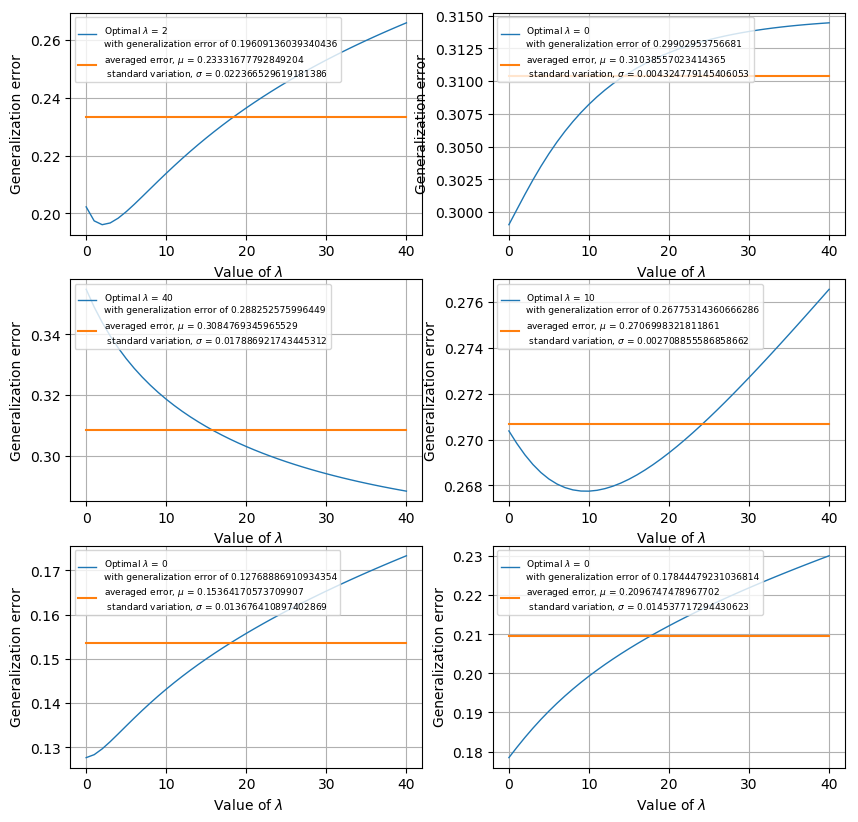

In [46]:
# Exercise 4 
np.random.shuffle(copy_data_train)
display(Markdown('## - <font color=\'red\'>In the figures we plot the the errors over the test sets for each '+r'$\lambda$'+' and the averaged value of the errors</font>'))
plt.figure(figsize=(10, 10), dpi=100)
for p in range(6):   # loop on test subsets
    # extraction of testset
    testset  = copy_data_train[arange(p*N_test,(p+1)*N_test),0:9]
    # extraction of trainset
    trainset = copy_data_train[hstack((arange(p*N_test),arange((p+1)*N_test,copy_data_train.shape[0]))),0:9]
    # normalization of entries,  
    normalized_trainset = np.array([normalize(vec) if np.std(vec)!=0 else vec for vec in trainset[:,0:8].T]).T  # iterate on vec direct / ARRAY not LIST
    normalized_testset = np.array([normalize(vec) if np.std(vec)!=0 else vec for vec in testset[:,0:8].T]).T
    # target values
    t_trainset = trainset[:,8] 
    t_testset = testset[:,8]
    # adding ones to test set
    final_testset = np.concatenate((np.ones((N_test,1)), normalized_testset), axis=1) 
    errors=[]
    for Lambda in lambda_pos:
        beta_hat=Regularized_least_squares(Lambda, t_trainset, normalized_trainset)
        error=la.norm([dot(final_testset,beta_hat)[i]-t_testset[i]  for i in range(len(t_testset))],2)
        errors.append((1/len(t_testset))*error)
    erros=np.array(errors)
    l=320+p+1
    plt.subplot(l)
    e = [i for i in range(len(errors)) if errors[i]==min(errors)]
    minimal_error=min(errors)
    plt.plot(errors,label='Optimal ' +r'$\lambda$ '+'= {Lambda} \nwith generalization error of {minimal_error}'.format(Lambda=e[0],minimal_error=minimal_error),linewidth=1)
    plt.plot([np.array(errors).mean() for i in range(len(errors))],label='averaged error, ' +r'$\mu$'+ ' = {mean}\n standard variation, '.format(mean=np.array(errors).mean())+r'$\sigma$'+' = {sigma}'.format(sigma=np.array(errors).std()))
    plt.grid(True)
    plt.xlabel(r' Value of $\lambda$')
    plt.ylabel('Generalization error')
    plt.legend(loc=2, prop={'size': 6.5})
    
    
        
        
        

## <font color='red'>The use of the 6-cross validation over one repartition of data set is not suffiscient to make a final claim about the optimal value of $\lambda$ and the averaged value of the errors.</font>

## <font color='red'> A way to estimate a best $\lambda$ would be by making more simulations of cross validations, each time with different repartitions of data over the sub sets. We choose the one that mimimizes the averaged error each time.</font>

## <font color='red'> [On fait l'hypothèse que si on obtient une valeur de $\lambda$ extrémale (0 ou 40 dans notre cas) on considère que l'estimation est mauvaise parce qu'elle dramatise la régularisation de l'erreur à minimiser sans forcément améliorer la performance du modèle. Ainsi, on supprime les valeurs extrémales de la liste des meilleurs valeurs de $\lambda$ calculées.]

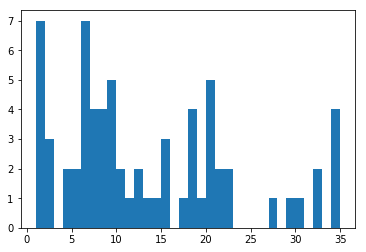

## - <font color='red'> The optimal value for a number of iterations n = 100 is : $\lambda$ = 13</font>

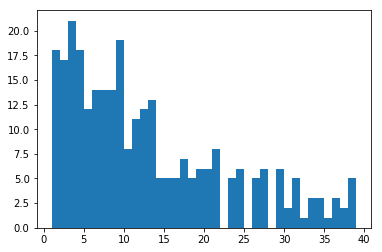

## - <font color='red'> The optimal value for a number of iterations n = 500 is : $\lambda$ = 12</font>

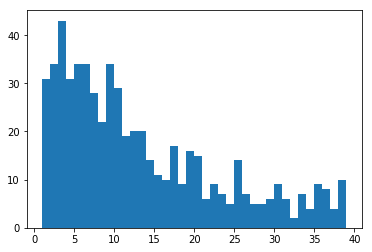

## - <font color='red'> The optimal value for a number of iterations n = 1000 is : $\lambda$ = 12</font>

In [44]:
# Exercise 4 
display(Markdown('## <font color=\'red\'>The use of the 6-cross validation over one repartition of data set is not suffiscient to make a final claim about the optimal value of '+r'$\lambda$'+' and the averaged value of the errors.</font>'))
display(Markdown('## <font color=\'red\'> A way to estimate a best '+r'$\lambda$'+' would be by making more simulations of cross validations, each time with different repartitions of data over the sub sets. We choose the one that mimimizes the averaged error each time.</font>'))
display(Markdown('## <font color=\'red\'> [On fait l\'hypothèse que si on obtient une valeur de '+r'$\lambda$'+' extrémale (0 ou 40 dans notre cas) on considère que l\'estimation est mauvaise parce qu\'elle dramatise la régularisation de l\'erreur à minimiser sans forcément améliorer la performance du modèle. Ainsi, on supprime les valeurs extrémales de la liste des meilleurs valeurs de '+r'$\lambda$'+' calculées.]')) 
import random

#The function multi_cross_validations takes a number of iterations "n" and returns the estimated optimal lambda after making
# n times 6-cross validations with different repartitions of sub sets. The description of the process is explained in the markdown below
#The function also plots the histogram of the list of values of lambda that minimazed the 6-cross validation

def multi_cross_validations(n:int)->int:
    SIZE=67
    best_lambdas=[]
    for p in range(n):   # loop on test subsets
        minimal_error=999
        optimal_lambda=0
        a=list(arange(0,SIZE))
        for t in range(6):
            idx = random.sample(a, 10)
            idx_bar=np.array([i for i in arange(0,SIZE) if i not in idx]) 
            testset  = copy.deepcopy(copy_data_train[idx,:][:,0:9])
            # extraction of trainset
            trainset = copy.deepcopy(copy_data_train[idx_bar,:][:,0:9]) 
            # normalization of entries,  
            normalized_trainset = np.array([normalize(vec) if np.std(vec)!=0 else vec for vec in trainset[:,0:8].T]).T  # iterate on vec direct / ARRAY not LIST
            normalized_testset = np.array([normalize(vec) if np.std(vec)!=0 else vec for vec in testset[:,0:8].T]).T
            # target values
            t_trainset = trainset[:,8] 
            t_testset = testset[:,8]
            # adding ones to test set
            final_testset = np.concatenate((np.ones((N_test,1)), normalized_testset), axis=1) 
            errors=[]
            for Lambda in lambda_pos:
                beta_hat=Regularized_least_squares(Lambda, t_trainset, normalized_trainset)
                error=la.norm([dot(final_testset,beta_hat)[i]-t_testset[i]  for i in range(len(t_testset))],2)
                errors.append((1/len(t_testset))*error)
            erros=np.array(errors)
            e = [i for i in range(len(errors)) if errors[i]==min(errors)]
            if np.array(errors).mean()<minimal_error:
                optimal_lambda=e[0]
                minimal_error=np.array(errors).mean()
            a=[i for i in a if i not in idx]
        if optimal_lambda not in [0,40]:
            best_lambdas.append(optimal_lambda)
    best_lambdas=np.array(best_lambdas)
    plt.hist(best_lambdas, bins=np.arange(best_lambdas.min(), best_lambdas.max()+1))
    plt.show()
    return int(np.array(best_lambdas).mean())

#Test with multiple iterations values :
for it in [100,500,1000]:
    display(Markdown('## - <font color=\'red\'> The optimal value for a number of iterations n = {it}'.format(it=it)+' is : '+r'$\lambda$'+' = {landa}'.format(landa=multi_cross_validations(it))+'</font>'))


        


        
        

# After multiple repetitions, an approximation of the optimal value of $\lambda$ was then  $\lambda$=12

In [19]:
#We calculate for another time the coefficients of regularized regression with our optimal lambda
beta_hat_reg_optimized=Regularized_least_squares(12,t, M_train[:,0:8])
display(pd.DataFrame(beta_hat_reg,columns=[r"Ridge regression result coefficients with optimal $\lambda$"]))

display(Markdown('# <font color=\'red\'>Question 2</font>'))
# Estimate the prediction error from the test set
Error=la.norm([dot(X_test,beta_hat_reg_optimized)[i]-t_test[i]  for i in range(len(t_test))],2)
display(Markdown('## $$E_ls =\\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = '+str((1/len(t_test))*Error)+'$$'))


,Ridge regression result coefficients with optimal $\lambda$
0,2.452345
1,0.427636
2,0.250478
3,-0.044402
4,0.167204
5,0.232723
6,0.006741
7,0.042464
8,0.132972


# <font color='red'>Question 2</font>

## $$E_ls =\frac{1}{N}(\sum_{i=0}^N |t\_test_i - predicion_i|^2)^{1/2} = 0.12744577152277364$$

## We can clearly see that the error obtained with the optimized value of  $\lambda$ is less (better) than with the value of 24 choosen in the exercice 3, but still bigger than the error calculated after the selection of features. Therfore, optimal regularization is not a final alternative to statistical tests for variables selections but helps assuming that the model we choose still can generalize the learning in a better way. Another idea would be to combine both the approches and calculate the regularizied model with the features already selected with the Z-scores test.